In [ ]:
# 参考 TensorFlow技术解析与实战 第9章 第1版1印 人民邮电出版社

In [55]:
import matplotlib.pyplot as plt

In [1]:
import tensorflow as tf
tf.__version__

'1.2.1'

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('./mnist/', one_hot=True)

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [38]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fb1d27d2da0>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fb1d27d2eb8>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fb1d27d2ef0>)

In [ ]:
# Softmax

In [5]:
x = tf.placeholder(tf.float32, [None, 784])
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))
y = tf.matmul(x, W) + b

In [6]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [7]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [8]:
for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

In [9]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9189


In [ ]:
# CNN

In [10]:
import numpy as np

In [11]:
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

In [12]:
trX = trX.reshape(-1, 28, 28, 1)
teX = teX.reshape(-1, 28, 28, 1)

In [13]:
X = tf.placeholder("float", [None, 28, 28, 1])
Y = tf.placeholder("float", [None, 10])

In [14]:
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [15]:
w = init_weights([3, 3, 1, 32])
w2 = init_weights([3, 3, 32, 64])
w3 = init_weights([3, 3, 64, 128])
w4 = init_weights([128 * 4 * 4, 625])
w_o = init_weights([625, 10])

In [16]:
def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    layer_1_a = tf.nn.relu(tf.nn.conv2d(X, w, strides=[1, 1, 1, 1], padding='SAME'))
    layer_1 = tf.nn.max_pool(layer_1_a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer_1 = tf.nn.dropout(layer_1, p_keep_conv)
    
    layer_2_a = tf.nn.relu(tf.nn.conv2d(layer_1, w2, strides=[1, 1, 1, 1], padding='SAME'))
    layer_2 = tf.nn.max_pool(layer_2_a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer_2 = tf.nn.dropout(layer_2, p_keep_conv)
    
    layer_3_a = tf.nn.relu(tf.nn.conv2d(layer_2, w3, strides=[1, 1, 1, 1], padding='SAME'))
    layer_3 = tf.nn.max_pool(layer_3_a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    layer_3 = tf.reshape(layer_3, [-1, w4.get_shape().as_list()[0]])
    layer_3 = tf.nn.dropout(layer_3, p_keep_conv)
    
    layer_4 = tf.nn.relu(tf.matmul(layer_3, w4))
    layer_4 = tf.nn.dropout(layer_4, p_keep_hidden)
    
    pyx = tf.matmul(layer_4, w_o)
    return pyx

In [17]:
p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

In [18]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y))
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

In [19]:
batch_size = 128
test_size = 256

In [20]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for i in range(10):
        training_batch = zip(range(0, len(trX), batch_size),
                            range(batch_size, len(trX) + 1, batch_size))
    
        for start, end in training_batch:
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end], p_keep_conv: 0.8, p_keep_hidden: 0.5})
    
        test_indices = np.arange(len(teX))
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:test_size]
    
        print(i, np.mean(np.argmax(teY[test_indices], axis=1) == sess.run(predict_op, feed_dict={X: teX[test_indices], p_keep_conv: 1.0, p_keep_hidden: 1.0})))

0 0.9609375
1 0.97265625
2 0.98828125
3 0.984375
4 1.0
5 0.99609375
6 0.98828125
7 0.984375
8 0.99609375
9 0.984375
10 1.0
11 0.984375
12 0.9921875
13 0.9921875
14 0.99609375
15 0.98828125
16 0.9921875
17 0.98828125
18 0.9921875
19 0.99609375
20 0.9921875
21 0.9921875
22 1.0
23 0.98046875
24 0.9921875
25 0.9921875
26 1.0
27 0.99609375
28 1.0
29 0.99609375
30 0.9921875
31 0.99609375
32 0.98828125
33 0.9921875
34 0.99609375
35 0.99609375
36 0.9921875
37 1.0
38 0.99609375
39 0.98828125
40 0.9921875
41 0.98828125
42 0.984375
43 0.99609375
44 0.99609375
45 1.0
46 0.9921875
47 0.9921875
48 0.9921875
49 1.0
50 0.98828125
51 0.99609375
52 0.99609375
53 0.99609375
54 1.0
55 0.9921875
56 0.9921875
57 0.99609375
58 0.9921875
59 0.99609375
60 0.99609375
61 0.99609375
62 0.99609375
63 0.984375
64 0.99609375
65 0.9921875
66 0.98828125
67 0.99609375
68 0.98828125
69 1.0
70 0.99609375
71 0.9921875
72 1.0
73 0.99609375
74 1.0
75 0.9921875
76 1.0
77 0.99609375
78 0.9921875
79 0.99609375
80 0.99609375
81

In [ ]:
# RNN

In [21]:
learning_rate = 0.001
training_iter = 1000
batch_size = 128

In [22]:
n_inputs = 28
n_steps = 28
n_hidden = 128
n_classes = 10

In [23]:
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_classes])

In [24]:
weights = {
    'in': tf.Variable(tf.random_normal([n_inputs, n_hidden])),
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}

biases = {
    'in': tf.Variable(tf.constant(0.1, shape=[n_hidden, ])),
    'out': tf.Variable(tf.constant(0.1, shape=[n_classes, ]))
}

In [25]:
def RNN(X, weights, biases):
    X = tf.reshape(X, [-1, n_inputs])
    
    X_in = tf.matmul(X, weights['in']) + biases['in']
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden])
    
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    
    init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
    
    outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, X_in, initial_state=init_state, time_major=False)
    
    results = tf.matmul(final_state[1], weights['out']) + biases['out']
    
    return results

In [ ]:
pred = RNN(x, weights, biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [28]:
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [35]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    step = 0
    while step * batch_size < training_iter:
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape([batch_size, n_steps, n_inputs])
        sess.run([train_op], feed_dict={x: batch_xs, y: batch_ys})
        if step % 20 == 0:
            print(sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys}))
        step += 1

0.171875
0.625
0.742188
0.78125
0.773438
0.84375
0.867188
0.875
0.921875
0.929688
0.914062
0.914062
0.898438
0.9375
0.9375
0.921875
0.898438
0.914062
0.945312
0.953125
0.9375
0.960938
0.96875
0.960938
0.945312
0.9375
0.953125
0.984375
0.960938
0.960938
0.96875
0.992188
0.984375
0.96875
0.960938
0.953125
0.96875
0.960938
0.96875
0.960938


In [ ]:
# Autoencoder

In [39]:
learning_rate = 0.01
training_epochs = 20
batch_size = 256
display_step = 1

In [41]:
examples_to_show = 10

In [42]:
n_input = 784
n_hidden_1 = 256
n_hidden_2 = 128

In [43]:
X = tf.placeholder("float", [None, n_input])

In [45]:
weights = {
    'encoder_h_1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h_2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h_1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h_2': tf.Variable(tf.random_normal([n_hidden_1, n_input]))
}

biases = {
    'encoder_b_1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b_2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b_1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b_2': tf.Variable(tf.random_normal([n_input]))
}

In [48]:
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h_1']), biases['encoder_b_1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h_2']), biases['encoder_b_2']))
    return layer_2

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h_1']), biases['decoder_b_1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h_2']), biases['decoder_b_2']))
    return layer_2

In [50]:
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

In [52]:
y_pred = decoder_op
y_true = X

cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

In [66]:
%matplotlib inline

Epoch: 0001 cost= 0.196035236
Epoch: 0002 cost= 0.163459286
Epoch: 0003 cost= 0.149455145
Epoch: 0004 cost= 0.141197577
Epoch: 0005 cost= 0.138070032
Epoch: 0006 cost= 0.130113289
Epoch: 0007 cost= 0.129311547
Epoch: 0008 cost= 0.124291569
Epoch: 0009 cost= 0.124397807
Epoch: 0010 cost= 0.123678580
Epoch: 0011 cost= 0.120689660
Epoch: 0012 cost= 0.117100038
Epoch: 0013 cost= 0.115663871
Epoch: 0014 cost= 0.113057241
Epoch: 0015 cost= 0.111616522
Epoch: 0016 cost= 0.111194789
Epoch: 0017 cost= 0.106270365
Epoch: 0018 cost= 0.104255401
Epoch: 0019 cost= 0.102420218
Epoch: 0020 cost= 0.101688147
Optimization Finished!


/home/unbuilt/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


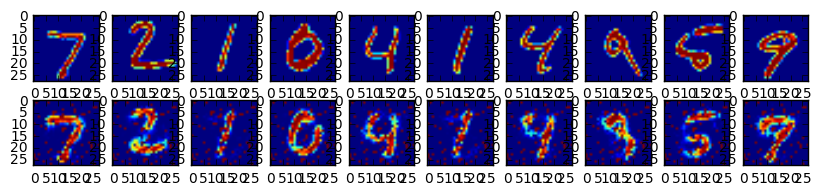

In [67]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    total_batch = int(mnist.train.num_examples / batch_size)
    for epoch in range(training_epochs):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(c))
    
    print("Optimization Finished!")
    
    encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
    
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    f.show()
    plt.draw()